# Homework 4

### start by reading in the four starting images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# unzip the faces.zip file into the folder containing Homework4.ipynb

# path to faces - need to reformat to work with your computer and operating system
path = './faces/'

# read in the four starting images
fisher   = plt.imread(path+'fisher.png')
stewart  = plt.imread(path+'stewart.png')
obama    = plt.imread(path+'obama.png')
cranston = plt.imread(path+'cranston.png')

# store the four faces in a list
# list with the 4 image matrices
face = [fisher, stewart, obama, cranston]
fnames = ['Fisher', 'Stewart', 'Obama', 'Cranston']
n_faces = len(face)

(fx, fy) = fisher.shape
flen = fx*fy
print('image size : ', fx, fy)

image size :  32 32


### view images

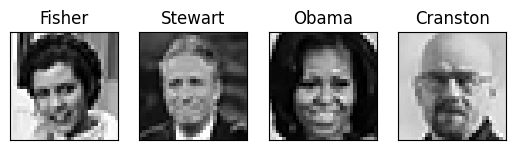

In [2]:
# view the four faces
for i in range(n_faces):
    plt.subplot(1, 4, i+1)
    plt.imshow(face[i], 'gray')
    plt.tick_params(axis='both', which='both',
                    bottom=False, top=False, labelbottom=False, 
                    right=False, left=False, labelleft=False)  
    plt.title(fnames[i])
plt.show()

### check image properties (values and types)

In [3]:
print('min pixel val of fisher : ', np.min(fisher))
print('max pixel val of fisher : ', np.max(fisher))
print('type in pixel : ', type(fisher[0,0]))

min pixel val of fisher :  0.0
max pixel val of fisher :  1.0
type in pixel :  <class 'numpy.float32'>


### center image around 0 and reshape into a 1D array rather than a 2D array

In [4]:
# preallocate numpy array to hold vectors of the four images
pats = np.zeros([n_faces, flen])

for i in range(n_faces):
    # reshape image
    p = face[i].reshape((flen,))
    
    # turn each image into a pattern ranging [-1 1]
    pats[i, :] = (p*2)-1
    
    # normalize each pattern to be unit length
    pats[i, :] = pats[i, :] / np.linalg.norm(pats[i, :])

### create noisy versions of each face to train network

In [5]:
import numpy.random as r

# create noisy versions of the image patterns 
n_train = 500

# amount of noise
noise_scale = 0.07

# preallocate training pattern array
train_pats = np.zeros([n_train*n_faces, flen])

idx = 0
# create noisy training patterns
for j in range(n_train):
    for i in range(n_faces):
        
        # normal noise with 0 mean and stdev 
        unit_noise = r.randn(flen)*noise_scale
        
        # add face with noise to produce training data
        train_pats[idx, :] = pats[i, :] + unit_noise
        
        # normalize activation to unit length
        train_pats[idx, :] = train_pats[idx, :] / np.linalg.norm(train_pats[idx, :])
        
        idx += 1

### display some of the noisy training patterns

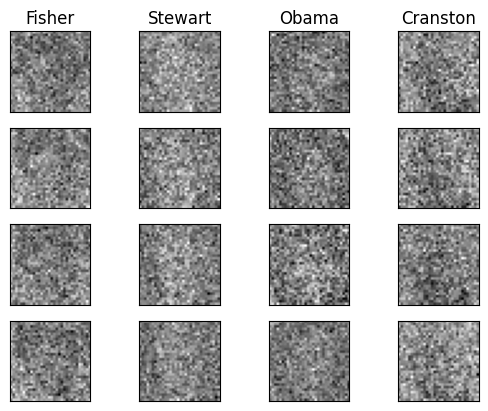

In [6]:
# you can play around with decreasing the noise level

for i in range(16):
    plt.subplot(4, 4, i+1)
    
    # reshape to square image
    this = train_pats[i, :].reshape([fx, fy])
    
    # convert back to [0 1] range
    this = (this+1)/2
    
    plt.imshow(this,'gray')
    
    plt.tick_params(axis='both',which='both',
          bottom=False,top=False,labelbottom=False,right=False,left=False,labelleft=False)   
    if i < 4:
        plt.title(fnames[i])

<hr>

<b>Q1.</b> Create a new 2000x4 numpy array called train_outs that has the “teacher” (output values you are training the network to reproduce) for each training pattern. For now, have the output of the correct answer equal to 1 and of the incorrect answers equal to 0.

Remember: You must not use hard-coded values. I have defined a lot of variables earlier in the code that you should use in your code.

In [7]:
import numpy as np
### enter Q1 answer here ###

# Initialize all "teacher" output vectors to be 0's
train_outs = np.zeros( (len(train_pats), n_faces) )

# Change element corresponding to face to 1's
for i in range(len(train_pats)):
    train_outs[i, i % 4] = 1

In [8]:
######### Testing #########
# train_outs[3] should be [0 0 0 1]
print(train_outs[3] == [0, 0, 0, 1])
print(train_outs[5] == [0, 1, 0, 0])

#train_outs[len(train_pats) - 1] should be 0 0 0 1
print("The final teacher output is: ", train_outs[len(train_pats) - 1])

[ True  True  True  True]
[ True  True  True  True]
The final teacher output is:  [0. 0. 0. 1.]


<hr>

<b>Q2.</b> Create a weight matrix with the appropriate dimensions. Initialize the weights in the matrix to random numbers drawn from a normal distribution. Normalize the weights so that the vector of weights contributing to the net input of any given output node has length equal to 1.

In [9]:
# Creating empty (1024, 4)-shape matrix
W = np.zeros((flen, n_faces))

for i in range(n_faces):
    # Initializing weights in matrix to random samples of normal distribution 
    W[:, i] = r.randn(flen)

    # Normalize the weights going into each output node
    W[:,i] = W[:,i] / np.linalg.norm(W[:,i])

In [10]:
##### TESTING ########

print(W.shape) # (1024, 4)
print(W[0,:]) # 4 random small value representing weights of edges going out of first input node
print(W.max(), W.min()) # Should be small (<.1)

# Getting junk prediction from sample pattern
# Dot product of a training pattern and Weight matrix to get prediciton
junk_prediction = train_pats[0].dot(W)
print("Prediction (weights uninitialized):", junk_prediction) # should be a bad prediction with test value [1 0 0 0]
print("Teacher:", train_outs[0])

(1024, 4)
[ 0.0684033  -0.07250498 -0.00590854  0.00912197]
0.10276650317585864 -0.10819776785212197
Prediction (weights uninitialized): [ 0.00503317 -0.02826891 -0.01707082  0.01660713]
Teacher: [1. 0. 0. 0.]


<hr>

<b>Q3.</b> Train the network using Oja’s rule. As described in class, for each of the 2000 patterns, the change in weight $Δw_{ij}$ between input node $i_{i}$ and output node $o_{j}$ is given by

$Δw_{ij} = λ \, i_{i} \, o_{j}$

where λ is the learning rate (assume λ = .01). If you stopped here, this would be Hebbian learning. For Oja’s rule, you will need to normalize the weights after updating the weights for each training pattern such that the vector of weights contributing to the net input of any given output node has length equal to 1 (you don’t normalize after every individual Δ$w_{ij}$ update, but after you update all the weights in the network).

Obviously, to train the network, you will need to write code to train the network. In Homework 3, we gave you Keras code to do the training. For this assignment, you need to write that training code from scratch. This should be only a few lines of code. It’s not complicated.

You do not need to worry about making your code efficient (vectorizing and the like) – you can if you want, but you do not have to. Slow is fine, so long as it runs correctly. Note that it will take a while to train the network (several minutes, depending on the speed of your computer). 

In [11]:
### enter Q3 answer here ###

learning_rate = 0.01
# For every training pattern

for i in range(len(train_pats)):
    # Grab training pattern and teacher

    train_pat = train_pats[i]
    train_out = train_outs[i]

    for i in range(flen):  # For each input node
        for j in range(n_faces): # between each output node
            # Change in wij = learning rate * activation of trainig pattern
            W[i,j] += learning_rate*train_pat[i]*train_out[j]

    # Normalize weights
    for i in range(n_faces):
        W[:,i] = W[:,i] / np.linalg.norm(W[:,i])


In [12]:
##### Testing ######
# Getting prediction of first_training pattern
fitted_prediction = train_pats[0].dot(W)
print("Prediction (weights initialized):", fitted_prediction) # should be a bad prediction with test value [1 0 0 0]
print("Teacher:", train_outs[0])

Prediction (weights initialized): [ 0.4057661  -0.08483818 -0.03201758 -0.04907268]
Teacher: [1. 0. 0. 0.]


<hr>

<b>Q4.</b> Visualize the weight going to each output unit of the network (like you did in Homework 3). You will need to produce four figures of “weight images”.

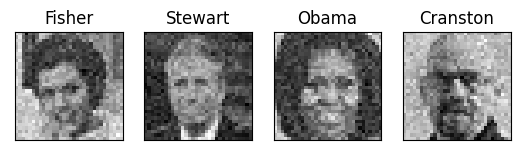

In [13]:
### enter Q4 answer here ###

# iterating over the four images
for i in range(n_faces):
    # we want to get the weights of the edges going into the ith output node
    input_weights = W[:, i]
    # and reshape these weights in to 32 x 32 array
    input_weights = input_weights.reshape((fx, fy))
    # next we plot the input weights
    plt.subplot(1, 4, i+1)
    plt.imshow(input_weights, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(fnames[i])




<hr>

<b>Q5.</b> Test your trained network. First, present each original image to the network (the four identities). Second, present a new noisy version (using the same level of noise used during training) of each of these images to the network. For each test image presented to the network, print out the correct answer and the answer produced by the network (winner-take-all).

Try creating a new set of four test images (one for each identity) with a higher level of noise that used during training that causes the network to make classification errors.

In [14]:
### enter Q5 answer here ###

# First present each original image to network

for i in range(n_faces):
    out = pats[i].dot(W)
    ind = np.argmax(out)
    print(f"Correct Answer: {fnames[i]}\t\t\t Predicted Answer: {fnames[ind]}")


Correct Answer: Fisher			 Predicted Answer: Fisher
Correct Answer: Stewart			 Predicted Answer: Stewart
Correct Answer: Obama			 Predicted Answer: Obama
Correct Answer: Cranston			 Predicted Answer: Cranston


In [15]:
# Second present new noisy version (using same level of noise used during training)
noise_scale = 0.07

for i in range(n_faces):
    pattern = pats[i] 
    pattern += r.randn(flen)*noise_scale
    out = pattern.dot(W)
    ind = np.argmax(out)
    print(f"Correct Answer: {fnames[i]}\t\t\t Predicted Answer: {fnames[ind]}")

Correct Answer: Fisher			 Predicted Answer: Fisher
Correct Answer: Stewart			 Predicted Answer: Stewart
Correct Answer: Obama			 Predicted Answer: Obama
Correct Answer: Cranston			 Predicted Answer: Cranston


Correct Answer: Fisher			 Predicted Answer: Fisher
Correct Answer: Stewart			 Predicted Answer: Stewart
Correct Answer: Obama			 Predicted Answer: Cranston
Correct Answer: Cranston			 Predicted Answer: Obama


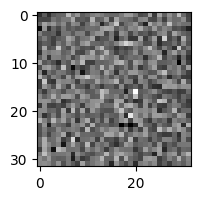

In [16]:
# Creating super noisy images, causing classification errors
noise_scale = 10

for i in range(n_faces):
    pattern = pats[i] 
    pattern += r.randn(flen)*noise_scale
    out = pattern.dot(W)
    ind = np.argmax(out)
    print(f"Correct Answer: {fnames[i]}\t\t\t Predicted Answer: {fnames[ind]}")

plt.figure(figsize=(4,2))
plt.imshow(pattern.reshape((fx,fy)), cmap="gray");

<hr>

<b>EXTRA CREDIT (2 point)</b>

See what happens when you change the coding for the output units from what was assumed above (the output of the correct answer equal to 1 and of the incorrect answers equal to 0) to a different coding of output units, with the output of the correct answer equal to 1 and the incorrect answers equal to -1). Retrain the network (like Q3), visualize the weights (like Q4), and test the network (like Q5).

Why does the visualization of the weights look different with this coding of output units from the one used in the main of the assignment? What is different about what is learned (and hence represented in the weights in the network) between the two ways of coding outputs? Add your written responses to a markdown cell in your assignment (an explanation is required to receive full extra credit).


In [25]:
### enter extra credit answer here ###

######## Modifying teacher output units #########

# Initialize all "teacher" output vectors to be 0's
train_outs = -1 * np.ones( (len(train_pats), n_faces) )

# Change element corresponding to face to 1's
for i in range(len(train_pats)):
    train_outs[i, i % 4] = 1

print(train_outs[0])

[ 1. -1. -1. -1.]


In [26]:
######## Retraining Network ########

learning_rate = 0.01

for i in range(len(train_pats)):

    train_pat = train_pats[i]
    train_out = train_outs[i]

    for i in range(flen):  
        for j in range(n_faces): 
            W[i,j] += learning_rate*train_pat[i]*train_out[j]

    for i in range(n_faces):
        W[:,i] = W[:,i] / np.linalg.norm(W[:,i])

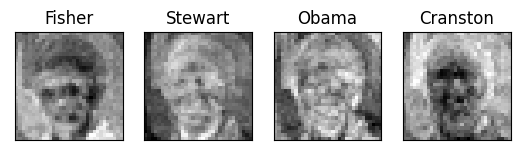

In [27]:
########### Visualizing the Weights #######
for i in range(n_faces):
    input_weights = W[:, i]
    input_weights = input_weights.reshape((fx, fy))
    plt.subplot(1, 4, i+1)
    plt.imshow(input_weights, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(fnames[i])


In [29]:
####### Testing Network #######
count = 0

# Regular images
for i in range(n_faces):
    out = pats[i].dot(W)
    ind = np.argmax(out)
    print(f"Correct Answer: {fnames[i]}\t\t\t Predicted Answer: {fnames[ind]}")
    if fnames[i] == fnames[ind]:
        count+=1

# Noisy Images
noise_scale = .7
for i in range(n_faces):
    pattern = pats[i] 
    pattern += (r.randn(flen) * noise_scale)
    out = pattern.dot(W)
    ind = np.argmax(out)
    print(f"Correct Answer: {fnames[i]}\t\t\t Predicted Answer: {fnames[ind]}")
    if fnames[i] == fnames[ind]:
        count+=1

print(f"Correctly classified {count}/8 faces ({100* count/8}%)")

Correct Answer: Fisher			 Predicted Answer: Stewart
Correct Answer: Stewart			 Predicted Answer: Stewart
Correct Answer: Obama			 Predicted Answer: Fisher
Correct Answer: Cranston			 Predicted Answer: Fisher
Correct Answer: Fisher			 Predicted Answer: Stewart
Correct Answer: Stewart			 Predicted Answer: Stewart
Correct Answer: Obama			 Predicted Answer: Fisher
Correct Answer: Cranston			 Predicted Answer: Fisher
Correctly classified 2/8 faces (25.0%)


## Extra-credit Explanation

The visualization of the weights looks different with this coding of output units because what is represented by the weights in the network has shifted from associating the activation of an input neuron with an `single` image, to associating the activation of an input neuron to all `4 images`.

For example, previously the `weight` of the edge from the first input neuron to the first output neuron was *only* changed by the `train_pats` and `train_outs` of image of Fisher (for other images, the activations of the first output neuron is 0, so $\Delta w_{00} = 0$). Therefore this weightonly encodes information about and becomes closer to the actual pixel value in the top left corner of the Fisher Image. 

When we modified the "teacher" output units so that incorrect outputs had activations of `-1`, now this corner weight also encodes information about the `difference` between pixel values in Fisher image and the other three images. For example, if both the first pixel in Fisher and Obama image are the same, then the changes in the weight incurred as a result of training on Fisher and Obama images will be `balanced out` (weight will not change much after training). 